In [51]:

import numpy as np
import importlib
from Graph import Graph
from helpers import *
import pandas as pd
import random
from tqdm import tqdm
from deterministic_attack import DeterministicAttack
from revisited_spectral import RevisitedSpectral
from erdos import SpectralAttack


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Exploring the spectral approach

In [52]:
dataset = "netscience"
G = Graph.from_txt(f"datasets/{dataset}.txt")
G1, G2 = G.split_dataset(common_prop=0.0, graph1_prop=0.0)
A = np.dot(G.adj_matrix, G.adj_matrix.T)

## Deterministic -> Heuristic -> Deterministic 

In [53]:
# Deterministic attack
deter = DeterministicAttack(G1, A)
deter.run()
Gstar = deter.get_reconstructed_graph()

# Revisited spectral attack
proba = RevisitedSpectral(Gstar, A)
n_nodes = Gstar.adj_matrix.shape[0]
proba.run(alpha=0.0, beta=0.0, gamma=0.0)
Gstar = proba.get_reconstructed_graph()
print("Errors after revisited:", np.sum(np.abs(Gstar.adj_matrix - G.adj_matrix)))
stats = ROC_stats(Gstar, G)
print("Before sanity check:", stats)
forgotten_slots = proba.sanity_check()
Gstar = proba.get_reconstructed_graph()
stats = ROC_stats(Gstar, G)
print("After sanity check:", stats)

# Deterministic attack
deter = DeterministicAttack(Gstar, A)
deter.run()
Gstar = deter.get_reconstructed_graph()
Gstar_fixed = Gstar.copy()
Gstar_fixed.fix_edges()
print("Errors :", np.sum(np.abs(Gstar_fixed.adj_matrix - G.adj_matrix)))




Triangle attack: 100%|██████████| 90/90 [00:00<00:00, 10238.06it/s]


+------+--------+
| Stat | Value  |
+------+--------+
|  0s  |  5723  |
|  1s  |  180   |
|  ?s  | 137738 |
+------+--------+ 



Triangle attack: 100%|██████████| 90/90 [00:00<00:00, 14754.25it/s]


+------+-------+
| Stat | Value |
+------+-------+
|  0s  | 44717 |
|  1s  |  180  |
|  ?s  | 98744 |
+------+-------+ 



Triangle attack: 100%|██████████| 90/90 [00:00<00:00, 13901.72it/s]


+------+-------+
| Stat | Value |
+------+-------+
|  0s  | 44717 |
|  1s  |  180  |
|  ?s  | 98744 |
+------+-------+ 



Revisited spectral attack: 100%|██████████| 379/379 [00:01<00:00, 207.30it/s]


Errors after revisited: 226
Before sanity check: (1714, 112, 141701, 114)
Updated 94244 edges in G*
After sanity check: (1604, 0, 117619, 0)


Triangle attack: 100%|██████████| 834/834 [00:00<00:00, 17217.52it/s]


+------+--------+
| Stat | Value  |
+------+--------+
|  0s  | 139659 |
|  1s  |  1668  |
|  ?s  |  2314  |
+------+--------+ 



Triangle attack: 100%|██████████| 841/841 [00:00<00:00, 19761.29it/s]


+------+--------+
| Stat | Value  |
+------+--------+
|  0s  | 141417 |
|  1s  |  1682  |
|  ?s  |  542   |
+------+--------+ 



Triangle attack: 100%|██████████| 855/855 [00:00<00:00, 17338.54it/s]


+------+--------+
| Stat | Value  |
+------+--------+
|  0s  | 141497 |
|  1s  |  1710  |
|  ?s  |  434   |
+------+--------+ 



Triangle attack: 100%|██████████| 872/872 [00:00<00:00, 10883.27it/s]


+------+--------+
| Stat | Value  |
+------+--------+
|  0s  | 141609 |
|  1s  |  1744  |
|  ?s  |  288   |
+------+--------+ 



Triangle attack: 100%|██████████| 901/901 [00:00<00:00, 11613.36it/s]


+------+--------+
| Stat | Value  |
+------+--------+
|  0s  | 141773 |
|  1s  |  1802  |
|  ?s  |   66   |
+------+--------+ 



Triangle attack: 100%|██████████| 905/905 [00:00<00:00, 19355.00it/s]


+------+--------+
| Stat | Value  |
+------+--------+
|  0s  | 141783 |
|  1s  |  1810  |
|  ?s  |   48   |
+------+--------+ 



Triangle attack: 100%|██████████| 908/908 [00:00<00:00, 16081.94it/s]


+------+--------+
| Stat | Value  |
+------+--------+
|  0s  | 141789 |
|  1s  |  1816  |
|  ?s  |   36   |
+------+--------+ 



Triangle attack: 100%|██████████| 908/908 [00:00<00:00, 18690.39it/s]

+------+--------+
| Stat | Value  |
+------+--------+
|  0s  | 141789 |
|  1s  |  1816  |
|  ?s  |   36   |
+------+--------+ 

Errors : 12


In [54]:
stats = ROC_stats(Gstar_fixed, G)
print(stats)

(1816, 0, 141813, 12)


## Erdos method

In [55]:
proba = SpectralAttack(A)
proba.run()
Gstar = proba.get_reconstructed_graph()
print("Errors after erdos:", np.sum(np.abs(Gstar.adj_matrix - G.adj_matrix)))

100%|██████████| 379/379 [00:00<00:00, 529.20it/s]

Errors after erdos: 380


## Analysis 

In [56]:
# Identifying the components of the graph that are not reconstructed

A_prime = np.dot(Gstar_fixed.adj_matrix, Gstar_fixed.adj_matrix.T)
slots_of_error = np.argwhere(A != A_prime)
nodes_of_error = set()
for i, j in slots_of_error:
    nodes_of_error.add(i)
    nodes_of_error.add(j)

nodes_of_error = list(nodes_of_error)

components = {}
hubs = []
for node in nodes_of_error:
    if A[node, node] == A_prime[node, node]:
        hubs.append(node)


for hub in hubs:
    components[hub] = []
    for node in nodes_of_error:
        if A[hub, node] != A_prime[hub, node]:
            components[hub].append(node)


for hub, nodes in components.items():
    print(f" --- Hub ----: {hub}")
    for node in nodes:
        print(f"Node : {node}, degree in A : {A[node, node]}, degree in A_prime : {A_prime[node, node]}")





 --- Hub ----: 69
Node : 327, degree in A : 3, degree in A_prime : 2
Node : 328, degree in A : 3, degree in A_prime : 2
Node : 377, degree in A : 3, degree in A_prime : 2
Node : 378, degree in A : 3, degree in A_prime : 2
 --- Hub ----: 302
Node : 327, degree in A : 3, degree in A_prime : 2
Node : 328, degree in A : 3, degree in A_prime : 2
Node : 377, degree in A : 3, degree in A_prime : 2
Node : 378, degree in A : 3, degree in A_prime : 2
 --- Hub ----: 22
Node : 226, degree in A : 2, degree in A_prime : 1
Node : 227, degree in A : 2, degree in A_prime : 1
Node : 53, degree in A : 2, degree in A_prime : 1
Node : 54, degree in A : 2, degree in A_prime : 1
 --- Hub ----: 25
Node : 197, degree in A : 2, degree in A_prime : 1
Node : 294, degree in A : 2, degree in A_prime : 1
Node : 295, degree in A : 2, degree in A_prime : 1
Node : 250, degree in A : 2, degree in A_prime : 1


# Identify cosquare components and construct cosquare graphs

In [57]:
G_prime_1 = Gstar_fixed.copy()
G_prime_2 = Gstar_fixed.copy()

for hub, nodes in components.items():
    G_prime_1.add_edge((nodes[0], nodes[1]))
    G_prime_1.add_edge((nodes[2], nodes[3]))    

    G_prime_2.add_edge((nodes[0], nodes[3]))
    G_prime_2.add_edge((nodes[1], nodes[2]))

    if len(nodes) > 4:
        G_prime_1.add_edge((nodes[4], nodes[5]))
        G_prime_2.add_edge((nodes[4], nodes[5]))

A_prime_1 = np.dot(G_prime_1.adj_matrix, G_prime_1.adj_matrix.T)
A_prime_2 = np.dot(G_prime_2.adj_matrix, G_prime_2.adj_matrix.T)


G_prime_1.to_txt(f"datasets/{dataset}_prime_1.txt")
G_prime_2.to_txt(f"datasets/{dataset}_prime_2.txt")

# Assert that the two graphs have the same sqquare
assert A_prime_1.all() == A_prime_2.all()
assert A_prime_1.all() == A.all()

# Assert that the two graphs are different
for hub, nodes in components.items():
    assert G_prime_1.adj_matrix[nodes[0], nodes[1]] == 1
    assert G_prime_1.adj_matrix[nodes[2], nodes[3]] == 1
    assert G_prime_2.adj_matrix[nodes[0], nodes[1]] == 0
    assert G_prime_2.adj_matrix[nodes[2], nodes[3]] == 0

    assert G_prime_1.adj_matrix[nodes[0], nodes[3]] == 0
    assert G_prime_1.adj_matrix[nodes[1], nodes[2]] == 0
    assert G_prime_2.adj_matrix[nodes[0], nodes[3]] == 1
    assert G_prime_2.adj_matrix[nodes[1], nodes[2]] == 1

# Extract context from the cosquare graphs

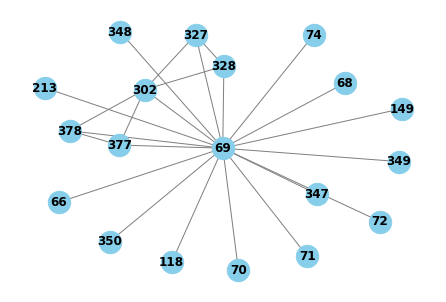

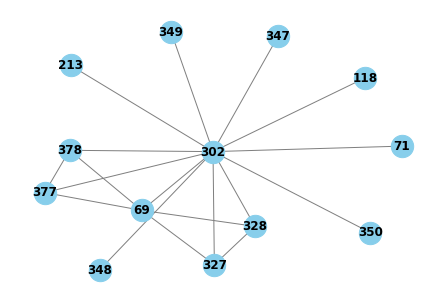

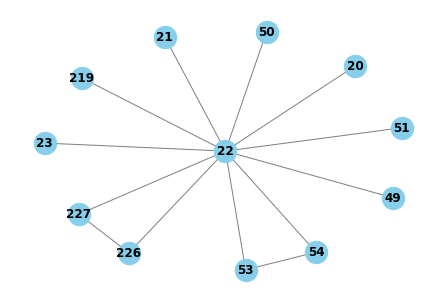

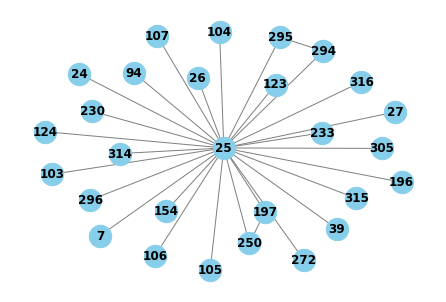

In [68]:
import networkx as nx 


for hub in hubs:
    context_nodes = []
    context_nodes.append(hub)
    for node in components.get(hub):
        context_nodes.append(node)


    G_context = nx.Graph()
    for node in context_nodes:
        for i in range(A.shape[0]):
            if G.adj_matrix[node, i] == 1:
                G_context.add_edge(node, i)

    nx.draw(G_context, with_labels=True, font_weight='bold', node_color='skyblue', node_size=600, edge_color='gray')
    plt.show()


